In [3]:
#Including all the necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy
import torch
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import cv2
from skimage.feature import hog

/storage/home/hpaceice1/vkondepudi3/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#performing the transform
LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])

In [5]:
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(args.annot_train_prime)
        elif subset == 'test':
            self.annot = pd.read_csv(args.annot_test_prime)
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(args.data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self._labels)         

In [6]:
#loading all the required test and train data
class NotebookArgs:
    def __init__(self, annot_train_prime = 'df_prime_train.csv', annot_test_prime = 'df_prime_test.csv', data_root = '/storage/home/hpaceice1/shared-classes/materials/ece8803fml/'):
        self.annot_train_prime = annot_train_prime
        self.annot_test_prime = annot_test_prime
        self.data_root = data_root
args = NotebookArgs()

In [7]:
trainset = OCTDataset(args, 'train', transform=transform)
testset = OCTDataset(args, 'test', transform=transform)

# Defining data loaders for both test and trainset
batch_size = 32

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [8]:
#getting one batch of data from data loader
def get_X_y_from_loader(loader):
    X, y = [], []
    for sample in tqdm(loader, total=len(loader)):
        images, labels = sample[0], sample[1]
        X.extend([a.numpy().flatten() for a in images])
        y.extend([a.numpy().flatten() for a in labels])
        break
    return X,y
X_train, y_train = get_X_y_from_loader(train_loader)
print(len(X_train[0]))
print(X_train[0].shape)
print(len(y_train))
print(y_train)

  0%|          | 0/758 [00:00<?, ?it/s]

50176
(50176,)
32
[array([0]), array([1]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([2]), array([1]), array([2]), array([1]), array([0]), array([2]), array([1]), array([1]), array([2]), array([1]), array([2]), array([0]), array([0]), array([1]), array([1]), array([2])]


In [9]:
image = X_train[25].reshape((224,224))
label = y_train[25]

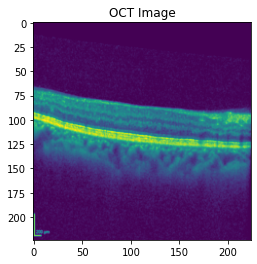

array([1])

In [10]:
from matplotlib import pyplot as plt
plt.title('OCT Image')
plt.imshow(image)
plt.show()

label

In [11]:
#implementing hog on one image
hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), orientations=2, block_norm='L2-Hys',
                              visualize=True, feature_vector=True)

In [12]:
hog_features.shape

(5832,)

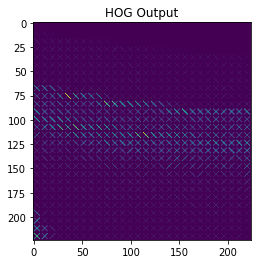

In [13]:
plt.title('HOG Output')
plt.imshow(hog_image)

In [14]:
#Checking for all labels in one batch
from collections import defaultdict
label_to_images = defaultdict(list)
for i in range(len(X_train)):
    label = y_train[i][0]
    image = X_train[i].reshape((224,224))
    label_to_images[label].append(image)
print('Total number of label 0 in this batch: ', len(label_to_images[0]))
print('Total number of label 1 in this batch: ', len(label_to_images[1]))
print('Total number of label 2 in this batch: ', len(label_to_images[2]))

Total number of label 0 in this batch:  5
Total number of label 1 in this batch:  20
Total number of label 2 in this batch:  7


In [15]:
hog_label_to_images = defaultdict(list)
for i in range(len(X_train)):
    label = y_train[i][0]
    image = X_train[i].reshape((224,224))
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), orientations=2, block_norm='L2-Hys',
                              visualize=True, feature_vector=True)
    hog_label_to_images[label].append(hog_image)

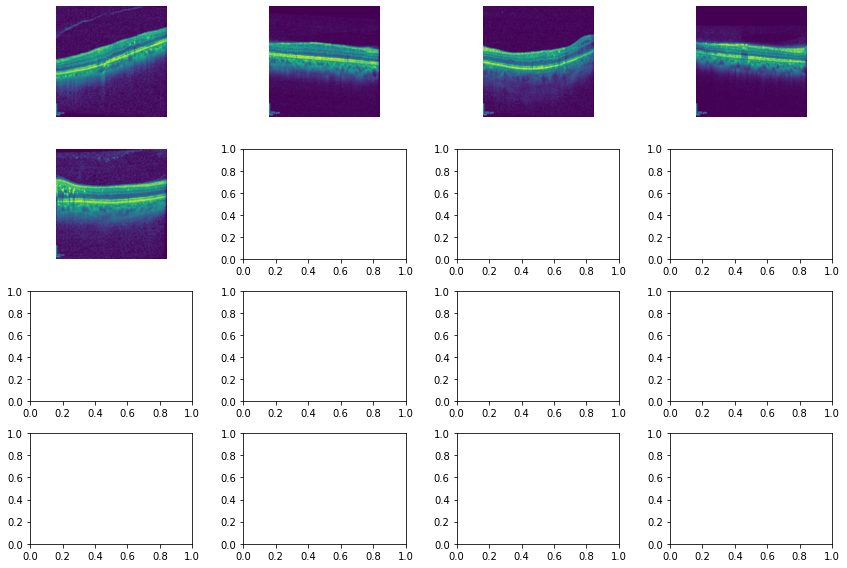

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 0
for i in range(len(label_to_images[CLASS])):
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

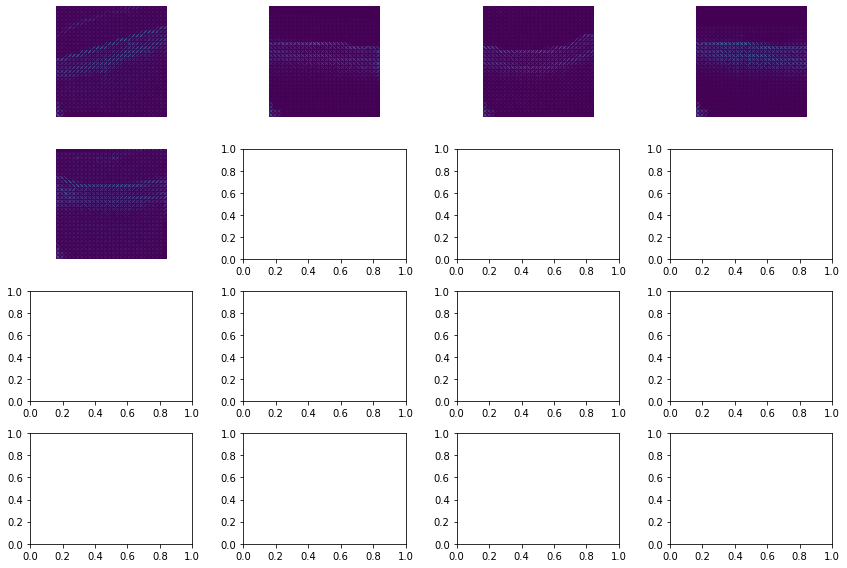

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 0
for i in range(len(hog_label_to_images[CLASS])):
    #if i == 12:
        #break
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(hog_label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

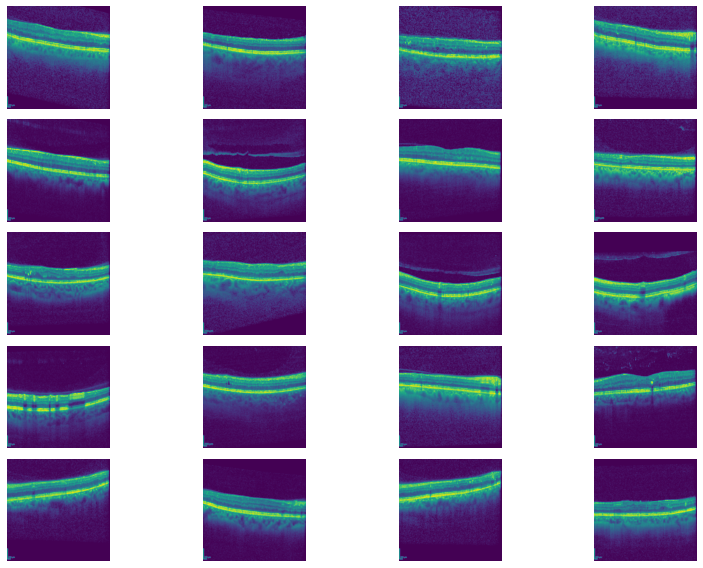

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 1
for i in range(len(label_to_images[CLASS])):
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

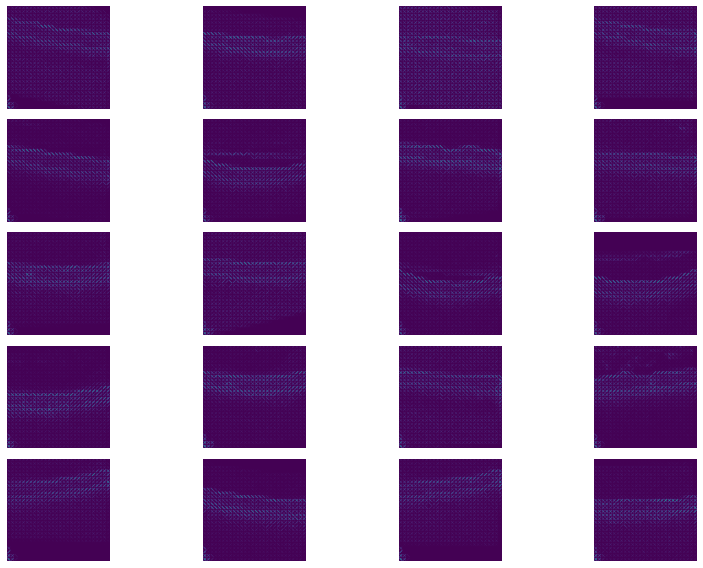

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 1
for i in range(len(hog_label_to_images[CLASS])):
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(hog_label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

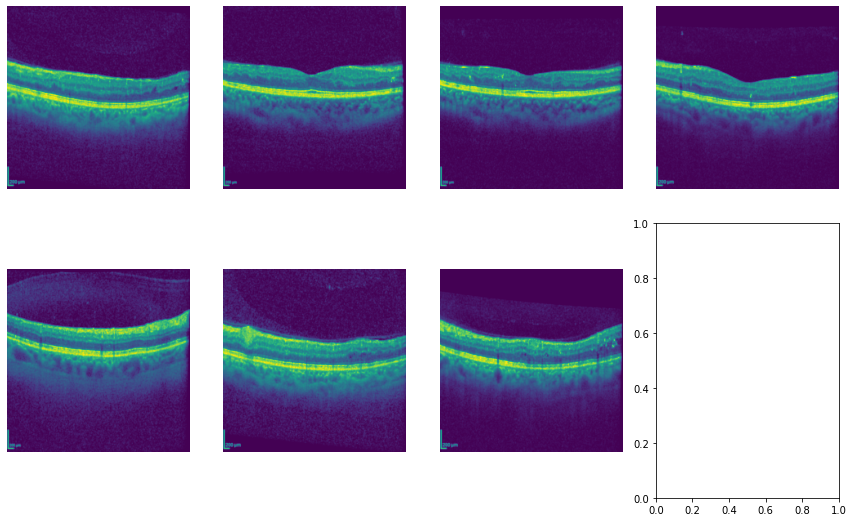

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 2
for i in range(len(label_to_images[CLASS])):
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

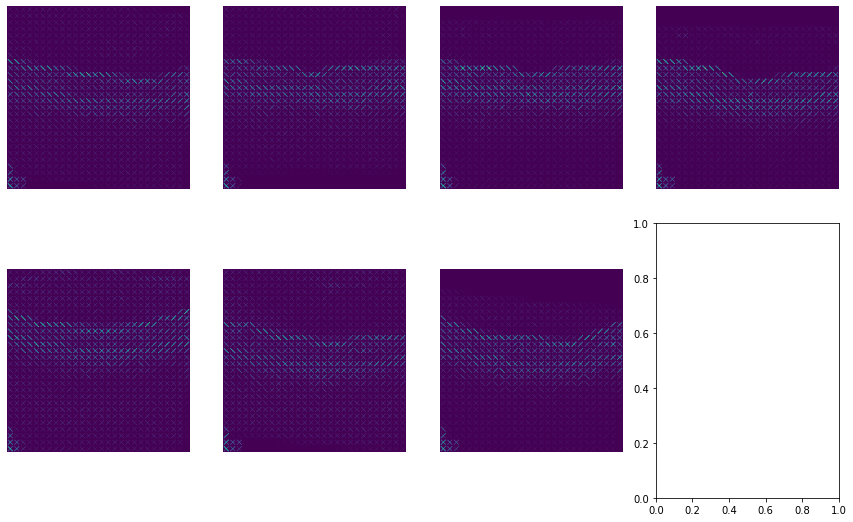

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

# Plot each image in a subplot
CLASS = 2
for i in range(len(hog_label_to_images[CLASS])):
    row = i // 4  # calculate the row number for the subplot
    col = i % 4   # calculate the column number for the subplot
    ax = axes[row][col]
    ax.imshow(hog_label_to_images[CLASS][i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [27]:
#load data from data loader
def get_X_y_from_loader(loader):
    X, y = [], []
    for sample in tqdm(loader, total=len(loader)):
        images, labels = sample[0], sample[1]
        X.extend([a.numpy()[0] for a in images])
        y.extend([a.numpy().flatten() for a in labels])
        #break
    return X,y

In [28]:
X_train, y_train = get_X_y_from_loader(train_loader)

100%|██████████| 758/758 [01:17<00:00,  9.75it/s]


In [29]:
X_test, y_test = get_X_y_from_loader(test_loader)

100%|██████████| 250/250 [00:24<00:00, 10.05it/s]


In [30]:
X_train_hog = []
for i in tqdm(range(len(X_train))):
    #X_hog = X_train[i].reshape((224,224))
    hog_features = hog(X_train[i], pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), orientations=2, block_norm='L2-Hys',
                              feature_vector=True)
    X_train_hog.append(hog_features)
print(X_train_hog[0].shape)
print(len(X_train_hog))

100%|██████████| 24252/24252 [10:37<00:00, 38.05it/s]

(5832,)
24252


In [28]:
#performing grid search
'''def train_svm(x_train,y_train):
    # Define SVM model
    clf = SVC()

    # Define hyperparameter grid to search over
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 1],
        'decision_function_shape': ['ovr', 'ovo']
    }

    # Create a grid search object with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

    # Fit the grid search object to the training data
    #for i, (x_train,y_train) in enumerate(x_train,y_train):
        #images = images.reshape(-1, 224*224)
    grid_search.fit(x_train,y_train)

    # Print the best hyperparameters and their corresponding score
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Train the model on the training set with the best hyperparameters
    clf = grid_search.best_estimator_
x_train_grid = X_train_hog[0:5000]

y_train_grid = y_train[0:5000]
y_train_grid  = np.ravel(y_train_grid )

svm_model = train_svm(x_train_grid,y_train_grid)'''

Best hyperparameters:  {'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf'}
Best score:  0.6831999999999999


In [ ]:
print(len(y_train))
X_subset = X_train_hog
y_subset = y_train

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=10, decision_function_shape='ovr',gamma=0.01)
clf.fit(X_subset, y_subset)

In [ ]:
X_test_hog = []
for i in tqdm(range(len(X_test))):
    #X_hog = X_train[i].reshape((224,224))
    hog_features = hog(X_test[i], pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), orientations=2, block_norm='L2-Hys',
                              feature_vector=True)
    X_test_hog.append(hog_features)
print(X_test_hog[0].shape)
print(len(X_test_hog))

In [28]:
# Make predictions on the testing data
y_pred = clf.predict(X_test_hog)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.46563165143357954


In [29]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

# Calculate balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy score:", balanced_acc)

# Calculate precision score
precision = precision_score(y_test, y_pred,average='weighted')
print("Precision score:", precision)

# Calculate recall score
recall = recall_score(y_test, y_pred,average='weighted')
print("Recall score:", recall)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='weighted')
print("F1 score weighted:", f1)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='micro')
print("F1 score Micro:", f1)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1 score Macro:", f1)

Balanced accuracy score: 0.383408872233757
Precision score: 0.43328170008022054
Recall score: 0.46563165143357954
F1 score weighted: 0.44229354538333493
F1 score Micro: 0.46563165143357954
F1 score Macro: 0.37549367350396706


In [ ]:
from sklearn.metrics import confusion_matrix

labels = [0, 1, 2]  # label names

cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print(cm_df)